# Intro to Data Analysis
## Final Project: Investigate Data

In this project I will:
1. Choose a dataset (titanic, baseball)
2. Analyse the data
3. Make questions based on the analysis
4. Report found answers

## Introduction

In this analysis report I would like to find some patterns or characteristics that make some players the best.<br>
After analysing the data I will use data analysis and statistics techniques using the libraries *Pandas*, *Numpy* and *Matplotlib* to manage datasets, make vectorized calculations and create visualisations to help understand the results.

### Questions

1. Which school did best players go to?
2. Did best players get highest salaries?
3. Is there a correlation between best teams and managers?

In [1]:
# import libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%pylab inline

from bokeh.io import output_notebook, show
from bkcharts import Donut
output_notebook()

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
# declare helper functions and load dataset
def load_files(data_path, filenames):
    dfs = {}
    for f in filenames:
        parts = f.split('.')
        if parts[1] != 'csv':
            continue
        dfname = parts[0]
        absfilename = data_path + '/' + f
        dfs[dfname] = pd.read_csv(absfilename)
    return dfs

def describe_df(df):
    print(df)
    display(dataframes[df].describe())
    print('')

def describe_dataframes(dataframes):
    for df in dataframes:
        describe_df(df)
        
def display_1d_array(array, col_name='Data'):
    display(pd.DataFrame(array, columns=[col_name], index=[i+1 for i in range(len(array))]))

In [3]:
# declare visualization functions
def stripplot(data, size=10, aspect=.25, titles=[], xvars=['W', 'L', 'score'], yvars=['teamID'], sort='score', xlabel='Score', ylabel='Y Label'):
    g = sns.PairGrid(data.sort_values(sort, ascending=False), x_vars=xvars, y_vars=yvars, size=size, aspect=aspect)
    g.map(sns.stripplot, size=size, orient="h",
          palette="Reds_r", edgecolor="gray")
    g.set(xlim=(-1, ceil(data[sort].max())), xlabel=xlabel, ylabel=ylabel)
    for ax, title in zip(g.axes.flat, titles):
        ax.set(title=title)
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
    sns.despine(left=True, bottom=True)


def distribution(data, figsize=(7, 5), color='c', xlabel='X', ylabel='Y', title=None):
    f, axes = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
    sns.despine(left=True)
    sns.distplot(data, color=color, kde_kws={"shade": True})
    axes.set(xlabel=xlabel, ylabel=ylabel)
    plt.setp(axes, yticks=[])
    plt.tight_layout()
    if title is not None:
        f.suptitle(title)


def plot_correlation(x, y, xlabel, ylabel, legend=None, title=None):
    if title is not None:
        fig = plt.figure()
        fig.suptitle(title)
    ax = sns.regplot(x="x", y="y", data=pd.DataFrame({'x': x, 'y': y}), label=legend, x_jitter=.2)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    if legend is not None:
        ax.legend(loc="best")


def plot_correlation2(data, x_var, y_var, title=None):
    sns.set(style="darkgrid", color_codes=True)
    g = sns.jointplot(x_var, y_var, data=data, kind="reg",
                      xlim=(0, data[x_var].max()), ylim=(0, data[y_var].max()), color="r", size=7)
    if title is not None:
        g.fig.suptitle(title)

In [4]:
# load data
data_path = 'data/baseballdatabank-2017.1/core'
filenames = os.listdir(data_path)
dataframes = load_files(data_path, filenames)

## Analyse data


### Main Table: Master

In [5]:
dataframes['Master'].head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


## Missing Values

In [6]:
rows_with_missing_values = len(dataframes['Master'][dataframes['Master'].isnull().any(axis=1)])
total = len(dataframes['Master'])

def bokeh_pie_chart(values, labels):
    data = pd.Series(values, index=labels)
    pie_chart = Donut(data)
    show(pie_chart)

bokeh_pie_chart([rows_with_missing_values, total-rows_with_missing_values], ['Rows with missing values', 'Rows without missing values'])

As you can see more than 50% of entries, only from *Master* table (players), have missing values. I could not find any relevant missing values directly on tables that could directly affect my calculations. However I had to deal with missing relationships between players and schools tables as you will see underneath.

## Report found answers

To answer any question about best players first I will have define what a best player is and how I will score it.

**Best Player**: Player who participated on most winning matches through time being part of one or more teams.

**Player/Team Score**: Ratio from the difference between Wins and Losses over amount of games played, assigned to every team.

## Wins

,yearID,W
count,2835.000000,2835.000000
mean,1955.681834,74.814109
std,41.767356,17.591208
min,1871.000000,0.000000
25%,1920.000000,66.000000
50%,1964.000000,77.000000
75%,1993.000000,87.000000
max,2016.000000,116.000000


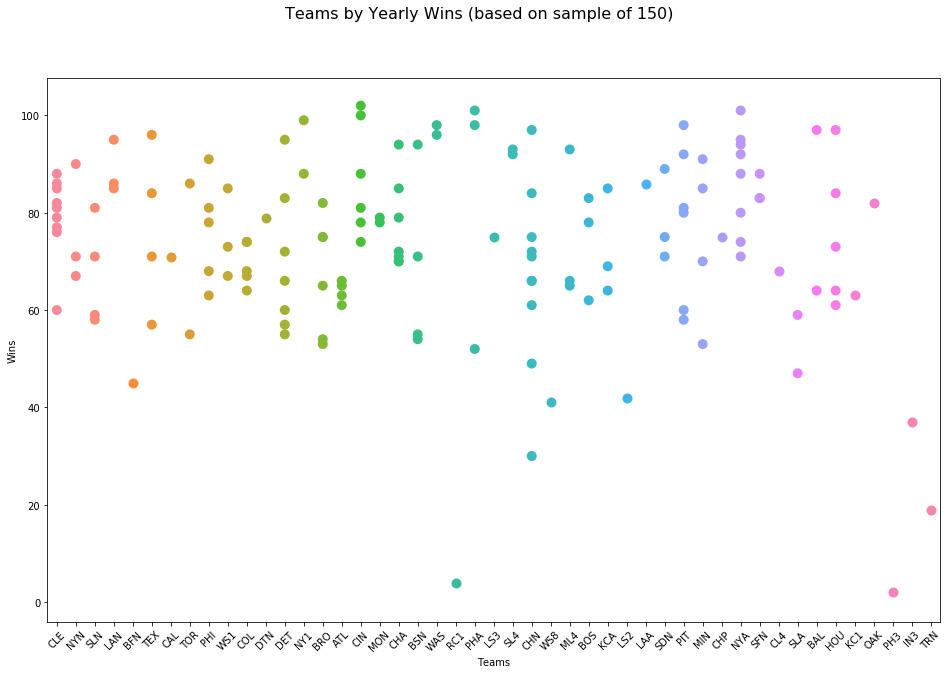

In [7]:
# Wins
team_wins_by_year = dataframes['Teams'].groupby(['teamID', 'yearID'], as_index=False)['teamID', 'W'].sum()
team_wins_by_year.sort_values('W', ascending=False).describe()
display(team_wins_by_year.describe())
team_wins_by_year_sample = team_wins_by_year.sample(n=150)
fig = plt.figure(figsize=(16,10))
ax = sns.stripplot(x="teamID", y="W", data=team_wins_by_year_sample, size=10)
for item in ax.get_xticklabels():
    item.set_rotation(45)
ax.set(xlabel='Teams', ylabel='Wins')
fig.suptitle('Teams by Yearly Wins (based on sample of 150)', fontsize=16);

In [8]:
team_wins_total = team_wins_by_year.groupby('teamID', as_index=False)['W'].sum()
display(team_wins_total.describe())

,W
count,149.000000
mean,1423.476510
std,2649.598666
min,0.000000
25%,43.000000
50%,118.000000
75%,1373.000000
max,10711.000000


*Some statistical numbers about Team Wins*

## Losses

,yearID,L
count,2835.000000,2835.000000
mean,1955.681834,74.814109
std,41.767356,17.331455
min,1871.000000,4.000000
25%,1920.000000,65.000000
50%,1964.000000,76.000000
75%,1993.000000,87.000000
max,2016.000000,134.000000


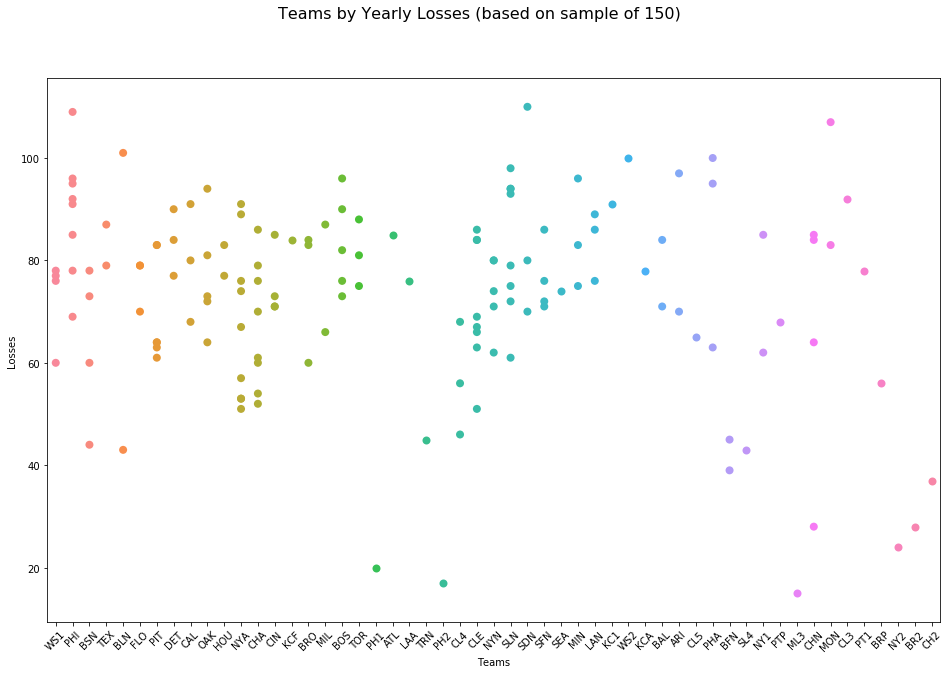

In [9]:
# losses
team_losses_by_year = dataframes['Teams'].groupby(['teamID', 'yearID'], as_index=False)['teamID', 'L'].sum()
team_losses_by_year.sort_values('L', ascending=False).describe()
display(team_losses_by_year.describe())
team_losses_by_year_sample = team_losses_by_year.sample(n=150)
fig = plt.figure(figsize=(16,10))
ax = sns.stripplot(x="teamID", y="L", data=team_losses_by_year_sample, size=8)
for item in ax.get_xticklabels():
    item.set_rotation(45)
ax.set(xlabel='Teams', ylabel='Losses')
fig.suptitle('Teams by Yearly Losses (based on sample of 150)', fontsize=16);

In [10]:
team_losses_total = team_losses_by_year.groupby('teamID', as_index=False)['L'].sum()
display(team_losses_total.describe())

,L
count,149.000000
mean,1423.476510
std,2570.942743
min,4.000000
25%,51.000000
50%,149.000000
75%,1575.000000
max,10741.000000


*And some more statistical numbers about Team Losses*

## Defining Scores
Any score will be calculated as follows: (wins - losses) / n_games.

In [11]:
# score formula
def calc_score(x):
    return (x['W'] - x['L']) / (x['W'] + x['L'])

In [12]:
teams_results = team_wins_total.merge(team_losses_total, on='teamID', how='inner')
tscores = teams_results.apply(calc_score, axis=1)
teams_results['score'] = tscores.values
display(tscores.describe())
display(teams_results.head())

count    149.000000
mean      -0.116981
std        0.290331
min       -1.000000
25%       -0.260759
50%       -0.039216
75%        0.035993
max        0.663717
dtype: float64

,teamID,W,L,score
0,ALT,6,19,-0.520000
1,ANA,664,632,0.024691
2,ARI,1503,1575,-0.023392
3,ATL,4174,3944,0.028332
4,BAL,5130,4864,0.026616


*Statistical information and first entries of Team Results*

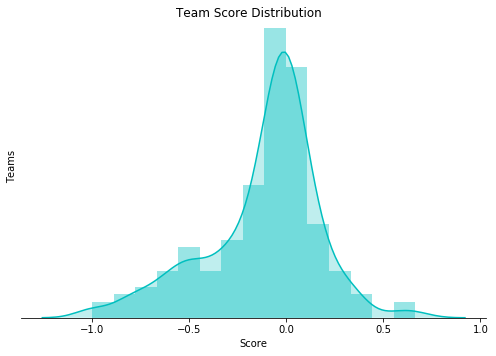

In [13]:
distribution(tscores, xlabel='Score', ylabel='Teams', title='Team Score Distribution')

## Best Teams
Since Teams are too many, I will take a sample using *Pandas' quantile* function set to 0.8 in order to get only the best 20% of best teams.

In [14]:
best_teams = teams_results[teams_results['score'] > teams_results.quantile(q=0.8)['score']].sort_values('score', ascending=False)
display(best_teams.describe())

,W,L,score
count,30.000000,30.000000,30.000000
mean,899.566667,693.766667,0.212257
std,2219.937413,1748.004334,0.142531
min,8.000000,4.000000,0.064220
25%,73.250000,47.250000,0.126745
50%,93.500000,61.000000,0.156710
75%,431.000000,335.000000,0.279741
max,10084.000000,7648.000000,0.663717


Now we have only 30 teams. If you check the previous figure the minimum score_norm was -1. Now it is 0.064, and max of 0.664.

## Best Teams

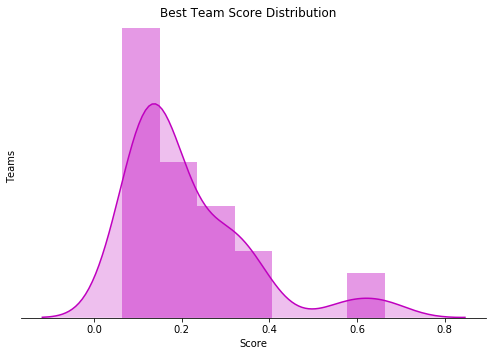

In [15]:
distribution(best_teams['score'].values, color='m', xlabel='Score', ylabel='Teams', title='Best Team Score Distribution')

## Best Players
Score range goes now from -3 to 3.

,W,L,score
count,18912.000000,18912.000000,18912.000000
mean,33523.823551,32767.876428,-0.016261
std,36578.098625,35322.251635,0.321425
min,0.000000,4.000000,-3.027457
25%,9082.000000,8707.000000,-0.112395
50%,19248.500000,18836.000000,0.006084
75%,48576.250000,47457.000000,0.074130
max,245091.000000,258283.000000,3.117700


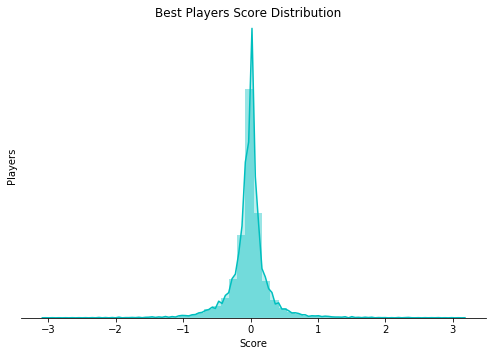

In [16]:
players_results = dataframes['Appearances'].merge(teams_results, on='teamID', how='inner').groupby(['playerID'], as_index=False)['W', 'L', 'score'].sum()
pscores = players_results['score'].values
display(players_results.describe())
distribution(pscores, xlabel='Score', ylabel='Players', title='Best Players Score Distribution')

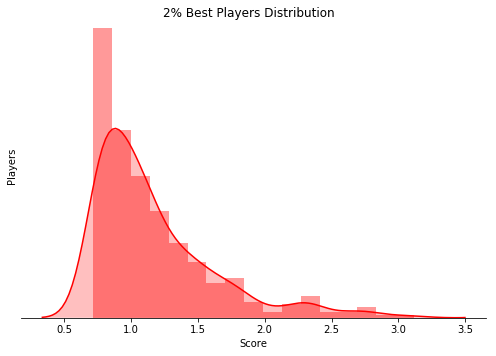

In [17]:
players_appearences = players_results.merge(dataframes['Appearances'].groupby('playerID', as_index=False)['teamID'].count(), on='playerID', how='left')
best_players_appearences = players_appearences[players_appearences['score'] > players_appearences.quantile(q=0.98)['score']]
distribution(best_players_appearences['score'].values, color='r', xlabel='Score', ylabel='Players', title='2% Best Players Distribution')

## Question 1
### Which school did winners go to?
Surprisingly, the best player regarding games played in winning teams, does not report school, as you can see below.

In [18]:
def set_to_str(x):
    x = ','.join([str(c) for c in x])
    return x
def set_to_count(x):
    if str(x) == '{nan}':
        return 0
    return len(x)
schools_of_winners = best_players_appearences.merge(dataframes['CollegePlaying'], on='playerID', how='left')
best_players_appearences_with_schools = best_players_appearences.merge(schools_of_winners, on='playerID', how='left').groupby('playerID', as_index=False).agg({'schoolID': lambda x: set(x)})
best_players_appearences_with_schools['school_count'] = best_players_appearences_with_schools['schoolID'].apply(set_to_count)
display(best_players_appearences_with_schools.merge(dataframes['Master'], on='playerID', how='left')[['playerID', 'nameGiven', 'schoolID', 'school_count']].head())

,playerID,nameGiven,schoolID,school_count
0,aaronha01,Henry Louis,{nan},0
1,adcocjo01,Joseph Wilbur,{lsu},1
2,alexado01,Doyle Lafayette,{nan},0
3,allenjo02,John Thomas,{nan},0
4,aloufe01,Felipe Rojas,{nan},0


*Almost none of best players report schools*

### Missing Relationships
I will have to exclude player entries with no schools in order to generate a ranking of best schools, based on best players who have reported one or more schools. To do so, I will count schools for each player, and then exclude those entries with school equal to zero.

### Top10 Schools regarding best players

In [19]:
best_players_with_school_and_score = best_players_appearences.merge(best_players_appearences_with_schools, on='playerID', how='left')
top10_schools = best_players_with_school_and_score[best_players_with_school_and_score['school_count'] > 0].sort_values('score', ascending=False).apply({'schoolID': lambda x: ','.join(x)}).iloc[0:10]
display_1d_array(top10_schools.values, col_name='School')

,School
1,columbia
2,alcalho
3,pennst
4,txsjjcn
5,ulala
6,bucknell
7,stbonny
8,fordham
9,casjcco
10,sliprock


*List ot top 10 schools*

## Question 2
### Did best players get the highest salaries?
Apparently participating in more winning games doesn't have a strict correlation with highest salaries, but they are still in a massive salaries list.
To calculate the salaries, I took the maximum salary for each player/team.

As you can see underneath, highest salaries didn't go to players of teams with more successful games.

In [20]:
def calculate_mean_salary(x):
    count = len(x)
    return ((1/count) * np.sum(x)/1000000)

best_players_salaries = dataframes['Salaries'].merge(best_players_with_school_and_score, on='playerID', how='right')[['playerID', 'salary', 'yearID', 'score']].dropna().sort_values(['salary'], ascending=False)
bpsalaries = best_players_salaries['salary'].values
#bscore_norm = MinMaxScaler().fit_transform(bpsalaries.astype(np.float64).reshape(-1, 1)).flatten()
#best_players_salaries['salary_norm'] = bpscore_norm

highest_salaries_players_with_score = best_players_salaries.groupby('playerID', as_index=False).agg({'salary': calculate_mean_salary}).merge(players_results, on='playerID', how='left')
display(highest_salaries_players_with_score[['salary', 'score']].describe())

,salary,score
count,81.000000,81.000000
mean,3.393315,1.100684
std,3.968022,0.428036
min,0.139167,0.720521
25%,0.774000,0.824273
50%,1.620000,0.978056
75%,5.037919,1.188719
max,18.109830,2.747575


*Statistical information of best players scores vs. salaries (expressed in millions of USD)*

In [21]:
max_salary_idx = highest_salaries_players_with_score[['salary']].idxmax()
max_score_idx = highest_salaries_players_with_score[['score']].idxmax()
print('Highest salary (millions)')
display(highest_salaries_players_with_score.loc[max_salary_idx].merge(dataframes['Master'], on='playerID', how='left')[['playerID', 'nameGiven', 'salary', 'score']])
print('Highest score')
display(highest_salaries_players_with_score.loc[max_score_idx].merge(dataframes['Master'], on='playerID', how='left')[['playerID', 'nameGiven', 'salary', 'score']])

Highest salary (millions)


,playerID,nameGiven,salary,score
0,rodrial01,Alexander Enmanuel,18.10983,1.188719


Highest score


,playerID,nameGiven,salary,score
0,jeterde01,Derek Sanderson,13.927268,2.747575


Here is the difference between the player getting the highest salary and the one participating the more winning games.

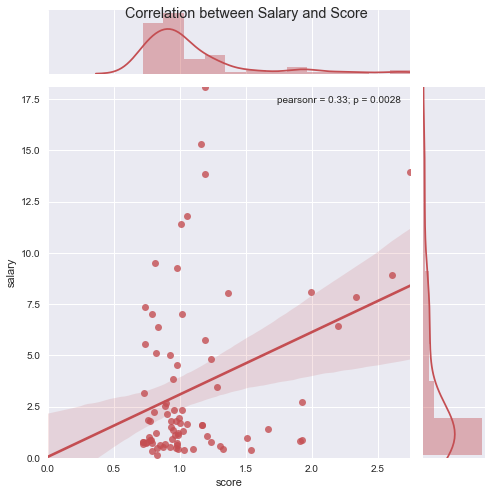

In [22]:
plot_correlation2(data=highest_salaries_players_with_score, x_var="score", y_var="salary", title='Correlation between Salary and Score')

Do best players get higher salaries? It is pretty difficult to see using only the variables on this report. It might be interesting to include more variables like manager biases or getting a better normalization of salaries (money does not have the same value now and 100 years ago).

## Question 3
### Is there a correlation between winning teams and managers?
Shapes are pretty similar, although the scales are different.

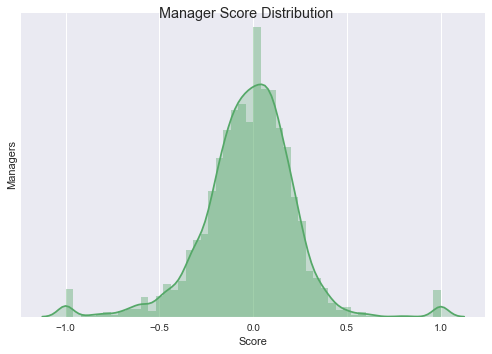

In [23]:
managers = dataframes['Managers']
mscores = managers.apply(calc_score, axis=1)
managers['score'] = mscores
managers = managers.groupby('playerID', as_index=False).sum()[['playerID', 'score', 'rank']]
best_managers = managers.sort_values('score', ascending=False)
distribution(mscores, color='g', xlabel='Score', ylabel='Managers', title='Manager Score Distribution')

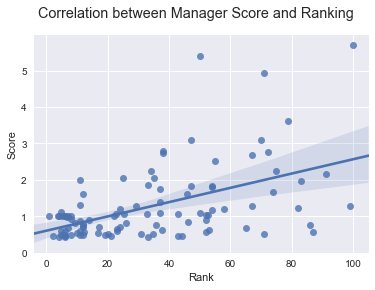

In [24]:
manager_rank_score_corr = best_managers.sort_values('score', ascending=False).iloc[0:100][['playerID', 'score', 'rank']]
plot_correlation(x=manager_rank_score_corr['rank'], y=manager_rank_score_corr['score'], xlabel='Rank', ylabel='Score', title='Correlation between Manager Score and Ranking')

It seems that best teams were managed by the best managers (or managers are considered the best because they won more games). This shows me how important leadership is to succeed.

## Limitations

I think there are many variables that I could include to see whether data could tell us anything more interesting, perhaps using Pitching, Fielding and Batting. Even curious patterns like birth or death places, or even doing the opposite job: finding patterns correlating with losing teams.

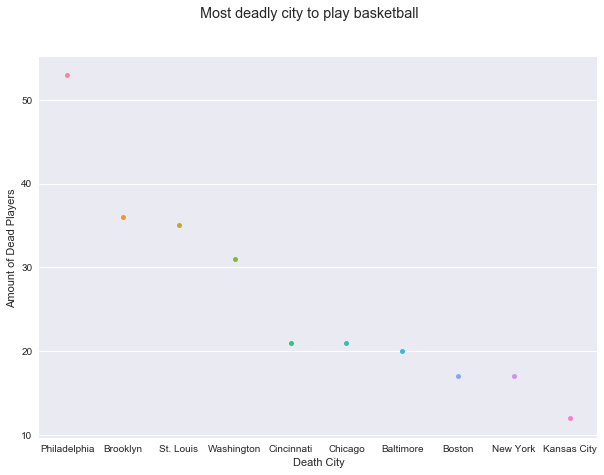

In [25]:
player_death_city = dataframes['Master'][['playerID', 'deathCity']].dropna().merge(players_results, on='playerID', how='left')
worst_players = player_death_city.sort_values('score')[['playerID', 'deathCity', 'score']].dropna()
top10_worst = worst_players[worst_players['score'] < worst_players.quantile(q=0.1)['score']].sort_values('score').groupby('deathCity', as_index=False)['playerID'].count().sort_values('playerID', ascending=False).iloc[0:10]
#display(top10_worst.iloc[0:10])
f, ax = plt.subplots(figsize=(10, 7))
sns.stripplot(x="deathCity", y="playerID", data=top10_worst)
ax.set(xlabel='Death City', ylabel='Amount of Dead Players')
f.suptitle('Most deadly city to play basketball');

## Conclusion

I've found that the best-reported player was *Henry Louis* (not reporting school).<br>
To answer the questions I had at the beginning, I've found that *Columbia* is the school with more best players. However, there were many missing relationships between players and the schools they went. This means that this school is only the best after ignoring best players who didn't report schools.

About highest salaries, *Alexander Emmanuel* seems to be the luckiest one with more than *USD 18M*. On the other hand, the one with the best-reported performance was *Derek Sanderson*.

Now, the most important fact, in my opinion, is the last question: Is there a correlation between best players and managers? Well, there is. I've found that leadership seems to be strongly involved in success: Players and teams were better with best-ranked managers.

## Dataset Reference
Sean Lahman, Award Winning Database Journalist and Author.

Website: http://www.seanlahman.com/baseball-archive/statistics/